# Mini-Projet : Détection et classification de panneaux de signalisation (GTSDB database)

On commence par importer les modules nécessaires :

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import cv2
import math

## Partie 1 - Exploration et préparation de la base

### 1. Visualisation et inspection rapide

#### Question 1.a

On commence par charger les annotations :

In [2]:
col_names = ['Filename', 'x1', 'y1', 'x2', 'y2', 'ClassId']
DATA_PATH = 'TrainIJCNN2013' 
gt_file = os.path.join(DATA_PATH, 'gt.txt')
df = pd.read_csv(gt_file, sep=';', names=col_names)
print(f"Annotations chargées : {len(df)} panneaux trouvés.")

Annotations chargées : 852 panneaux trouvés.


In [3]:
df.head()

,Filename,x1,y1,x2,y2,ClassId
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39


On définit une fonction d'affichage :

In [4]:
def visualize_samples(df, num_samples=5):
    # Sélection de quelques images uniques aléatoirement
    unique_images = df['Filename'].unique()
    # On prend les 5 premières images
    sample_files = unique_images[:num_samples] 
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 10))
    
    for ax, img_file in zip(axes, sample_files):
        img_path = os.path.join(DATA_PATH, img_file)
        
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            
            # Récupération de toutes les annotations pour cette image précise
            img_annotations = df[df['Filename'] == img_file]
            
            for _, row in img_annotations.iterrows():
                # Création du rectangle
                width = row['x2'] - row['x1']
                height = row['y2'] - row['y1']
                
                rect = patches.Rectangle(
                    (row['x1'], row['y1']), 
                    width, 
                    height, 
                    linewidth=2, 
                    edgecolor='r', 
                    facecolor='none'
                )
                ax.add_patch(rect)
                
            ax.set_title(f"Fichier: {img_file}")
            ax.axis('off')
            
        except FileNotFoundError:
            ax.text(0.5, 0.5, "Image introuvable", ha='center')
            ax.set_title(img_file)

    plt.show()

On exécute la visualisation :

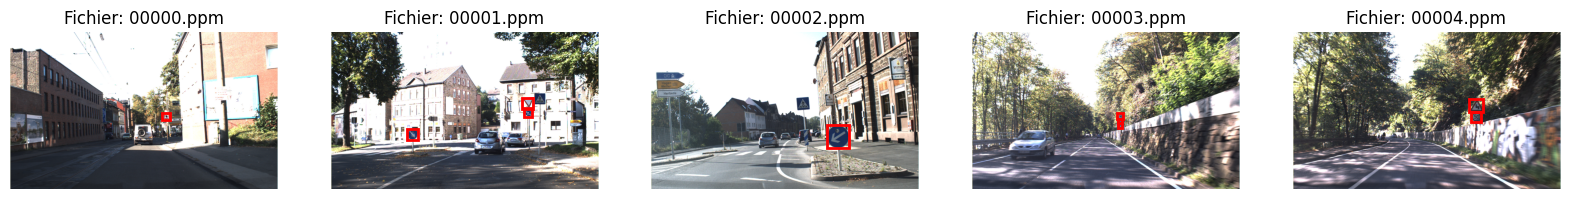

In [5]:
visualize_samples(df, num_samples=5)

#### Question 1.b

On peut représenter les dimensions des panneaux :

            Width      Height
count  852.000000  852.000000
mean    43.395540   42.751174
std     22.349686   21.503074
min     16.000000   16.000000
25%     27.000000   27.000000
50%     38.000000   37.000000
75%     53.000000   52.000000
max    127.000000  128.000000


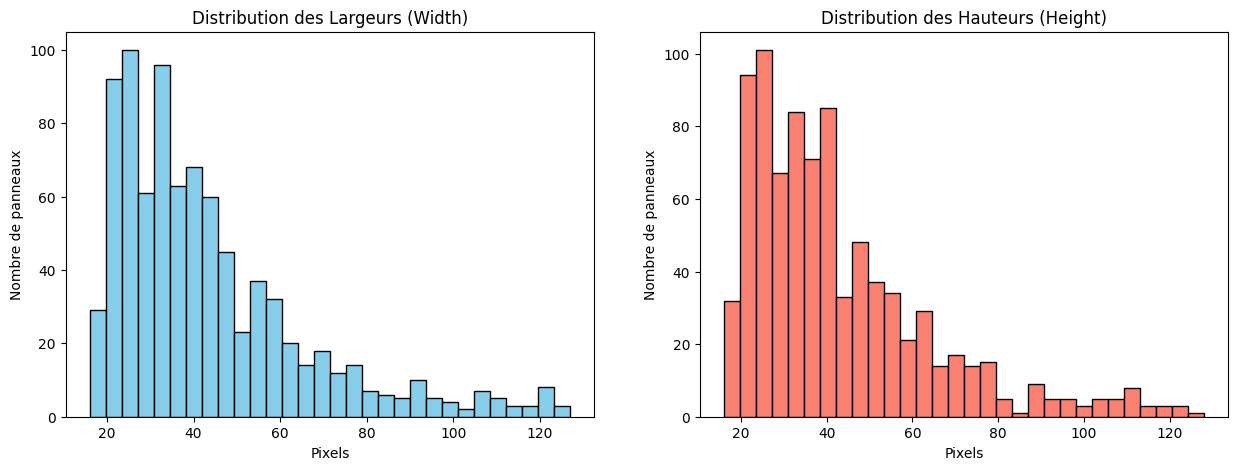

In [6]:
# Calcul des largeurs et hauteurs des panneaux
df['Width'] = df['x2'] - df['x1']
df['Height'] = df['y2'] - df['y1']

# Affichage des statistiques descriptives
print(df[['Width', 'Height']].describe())

# Visualisation de la distribution des tailles
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(df['Width'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution des Largeurs (Width)')
plt.xlabel('Pixels')
plt.ylabel('Nombre de panneaux')

plt.subplot(1, 2, 2)
plt.hist(df['Height'], bins=30, color='salmon', edgecolor='black')
plt.title('Distribution des Hauteurs (Height)')
plt.xlabel('Pixels')
plt.ylabel('Nombre de panneaux')

plt.show()

In [7]:
df.head()

,Filename,x1,y1,x2,y2,ClassId,Width,Height
0,00000.ppm,774,411,815,446,11,41,35
1,00001.ppm,983,388,1024,432,40,41,44
2,00001.ppm,386,494,442,552,38,56,58
3,00001.ppm,973,335,1031,390,13,58,55
4,00002.ppm,892,476,1006,592,39,114,116


On remarque qu'il y a une très grande variabilité dans la taille des cadres autour des panneaux. Ces derniers varient de moins de 20 pixels de côté à plus de 120 pixels de côté. Ainsi, le redimensionnement vers une taille fixe sera destructeur pour les grands panneaux et créera du flou pour les petits panneaux (upscaling).

Les conditions d'éclairage changent drastiquement. L'image `00000.ppm` présente un fort contraste avec des ombres marquées, tandis que l'image `00004.ppm` est prise dans une zone ombragée où les panneaux sont sombres et peu contrastés par rapport au fond.

Les fonds sont complexes. Sur l'image `00004.ppm`, le panneau est entouré de feuillage, ce qui rend les contours moins nets.

Les panneaux ne sont pas toujours parfaitement de face. Il y a des rotations légères ou des perspectives qui déforment le ratio hauteur/largeur du panneau.

### 2. Extraction des imagettes de panneaux

On définit une fonction qui extraie et redimensionne les imagettes à partir de chaque image :

In [8]:
IMG_SIZE = 32

def extract_and_resize_signs(df, data_path, target_size=(IMG_SIZE, IMG_SIZE)):
    X = [] # Stockage des pixels des images
    y = [] # Stockage des classes (labels)
    
    for index, row in df.iterrows():
        try:
            img_path = os.path.join(data_path, row['Filename'])
            img = Image.open(img_path)
            
            # Extraction
            region = img.crop((row['x1'], row['y1'], row['x2'], row['y2']))
            
            # Redimensionnement
            region = region.resize(target_size, Image.Resampling.LANCZOS)
            
            # Conversion en tableau numpy et stockage
            X.append(np.array(region))
            y.append(row['ClassId'])
            
        except Exception as e:
            print(f"Erreur sur l'image {row['Filename']} index {index}: {e}")
            
    return np.array(X), np.array(y)

On exécute l'extraction et le redimensionnement des images :

In [9]:
X, y = extract_and_resize_signs(df, DATA_PATH)

print(f"\nExtraction terminée.")
print(f"Dimension de X (Images) : {X.shape}")
print(f"Dimension de y (Labels) : {y.shape}")


Extraction terminée.
Dimension de X (Images) : (852, 32, 32, 3)
Dimension de y (Labels) : (852,)


On affiche quelques imagettes extraites pour vérifier que le redimensionnement est bon :

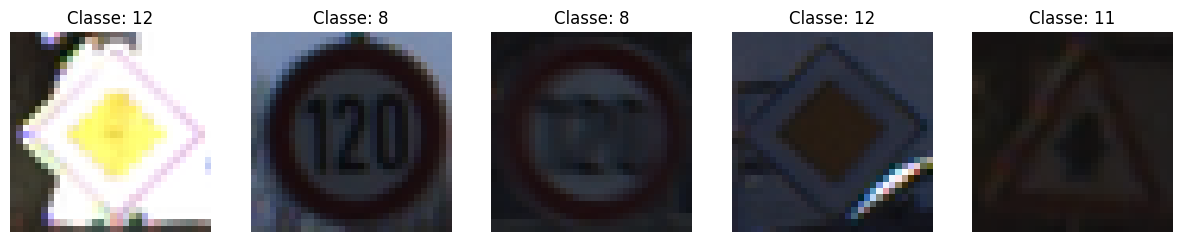

In [10]:
plt.figure(figsize=(15, 3))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    # On prend un index aléatoire
    idx = np.random.randint(0, len(X))
    plt.imshow(X[idx])
    plt.title(f"Classe: {y[idx]}")
    plt.axis("off")
plt.show()

### 3. Filtrage des classes

#### Question 3.a

On calcule le nombre de pixels par classe :

In [11]:
unique, counts = np.unique(y, return_counts=True)
print(f"Nombre total de classes au départ : {len(unique)}")

Nombre total de classes au départ : 43


On peut visualiser la distribution des classes :

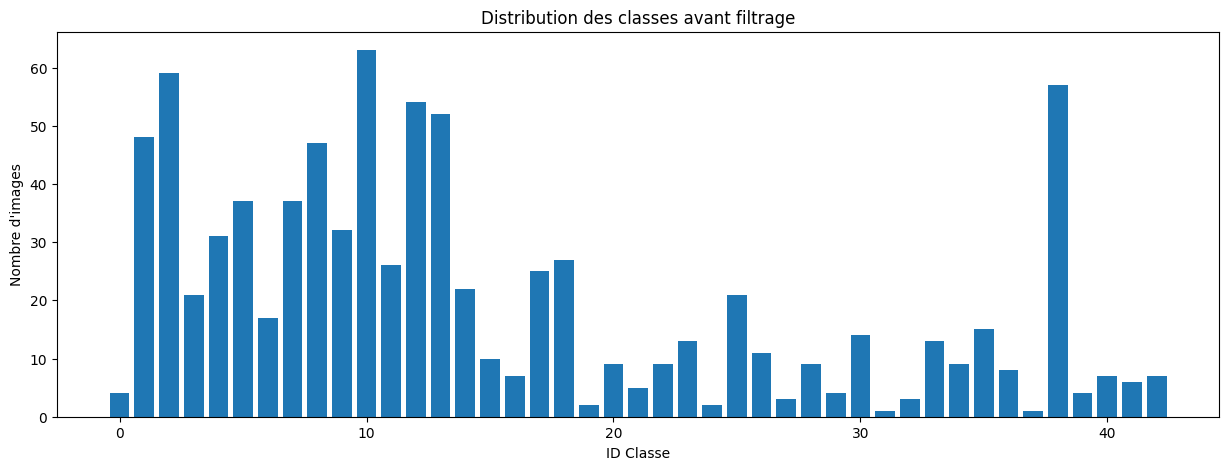

In [12]:
# Création d'un dictionnaire pour visualiser
class_counts = dict(zip(unique, counts))

# Visualisation
plt.figure(figsize=(15, 5))
plt.bar(unique, counts)
plt.title("Distribution des classes avant filtrage")
plt.xlabel("ID Classe")
plt.ylabel("Nombre d'images")
plt.show()

#### Question 3.b

On identifie les les classes les plus fréquentes (avec plus de 20 imagettes) :

In [13]:
valid_classes = [cls for cls, count in class_counts.items() if count > 20]

On créé des masques booléens pour filtrer `X` et `y` :

In [14]:
mask = np.isin(y, valid_classes)

X_filtered = X[mask]
y_filtered = y[mask]

On réencode les labels en gardant les IDs originaux pour la traçabilité et en notant le nombre de classes restantes pour la couche de sortie du réseau :

In [15]:
unique_filtered = np.unique(y_filtered)

print(f"Filtrage terminé.")
print(f"Nombre de classes restantes : {len(unique_filtered)}")
print(f"Nombre d'images restantes : {len(X_filtered)} (sur {len(X)} au départ)")

Filtrage terminé.
Nombre de classes restantes : 17
Nombre d'images restantes : 659 (sur 852 au départ)


#### Question 3.c

On découpe les données, pour cela on utilise l'option `stratify=y` pour s'assurer que chaque jeu (val/train/test) a la même proportion de panneaux de chaque classe que le jeu complet. On sépare train (70%) et le reste (30%) :

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, y_filtered, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_filtered
)

On sépare ensuite le reste en validation (15%) et test (15%) :

In [17]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, 
    random_state=42, 
    stratify=y_temp
)

Voici les dimensions des jeux de données :

In [18]:
print(f"Train      : X={X_train.shape}, y={y_train.shape}  (~{len(X_train)/len(X_filtered):.0%})")
print(f"Validation : X={X_val.shape},  y={y_val.shape}   (~{len(X_val)/len(X_filtered):.0%})")
print(f"Test       : X={X_test.shape},  y={y_test.shape}   (~{len(X_test)/len(X_filtered):.0%})")

Train      : X=(461, 32, 32, 3), y=(461,)  (~70%)
Validation : X=(99, 32, 32, 3),  y=(99,)   (~15%)
Test       : X=(99, 32, 32, 3),  y=(99,)   (~15%)


## Partie 2 - Classification avec un MLP

### 1. Préparation des données

#### Question 1.a

On normalise les pixels :

In [19]:
X_train_norm = X_train.astype('float32') / 255.0
X_val_norm = X_val.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

#### Question 1.b

Nous avons tenté d'appliquer de la Data Augmentation (rotations, zooms) avec le générateur suivant :

```python
datagen = ImageDataGenerator(
    rotation_range=5,       # Petites rotations (-10 à +10 degrés)
    width_shift_range=0.05,   # Translations horizontales (10%)
    height_shift_range=0.05,  # Translations verticales (10%)
    brightness_range=[0.9, 1.1], # Légères variations de luminosité (+/- 20%)
    zoom_range=0.05,          # Zoom léger (10%)
    horizontal_flip=False,   # Pas de miroir horizontal pour les panneaux (sens interdit, flèches...)
    fill_mode='nearest'      # Remplissage des pixels créés par le décalage
)
```

Cependant, cela a drastiquement fait chuter les performances (accuracy ~20%). Nous analysons que sur des images de si basse résolution (32x32), les transformations détruisent les caractéristiques visuelles essentielles des panneaux. Nous avons donc conservé le modèle sans augmentation qui offre une performance solide (plus de 80% sur le jeu de test pour le MLP par exemple).

#### Question 1.c

On commence par mapper les classes existantes vers 0, 1, 2, ..., N (comme les classes ne sont pas continues) :

In [20]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Nombre de classes finales
num_classes = len(np.unique(y_train_enc))
print(f"Nombre de classes pour le modèle : {num_classes}")

Nombre de classes pour le modèle : 17


Ensuite, on transforme en vecteurs binaires :

In [21]:
y_train_cat = to_categorical(y_train_enc, num_classes)
y_val_cat = to_categorical(y_val_enc, num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes)

### 2. Conception du MLP

On définit un MLP :

In [22]:
model_mlp = Sequential([
    # Couche d'entrée : on définit la forme de l'image (32, 32, 3)
    Input(shape=(32, 32, 3)),
    
    # Aplatissement : on transforme l'image 2D en vecteur 1D
    Flatten(),
    
    # Couches cachées (Fully Connected)
    Dense(256, activation='relu'),  # Couche 1 : 256 neurones
    Dense(128, activation='relu'),  # Couche 2 : 128 neurones
    
    # Couche de sortie avec softmax pour obtenir des probabilités par classe
    Dense(num_classes, activation='softmax')
])

E0000 00:00:1764211010.207424 4164736 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1764211010.217828 4164736 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Voici un résumé du modèle :

In [23]:
model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,777 (3.13 MB)

 Trainable params: 821,777 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

### 3. Entraînement

#### Question 3.a

On compile le modèle :

In [24]:
model_mlp.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

On entraîne le modèle sur `X_train_norm` et `y_train_cat` :

In [25]:
history = model_mlp.fit(
    x=X_train_norm, 
    y=y_train_cat,
    batch_size=32,
    epochs=30, 
    validation_data=(X_val_norm, y_val_cat),
    verbose=1
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2148 - loss: 2.6748 - val_accuracy: 0.4141 - val_loss: 2.2336
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4425 - loss: 2.0222 - val_accuracy: 0.4343 - val_loss: 1.8443
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5249 - loss: 1.6950 - val_accuracy: 0.5152 - val_loss: 1.6321
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5922 - loss: 1.4372 - val_accuracy: 0.5556 - val_loss: 1.5208
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6247 - loss: 1.2958 - val_accuracy: 0.5859 - val_loss: 1.3433
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6551 - loss: 1.1353 - val_accuracy: 0.5859 - val_loss: 1.3628
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7028 - loss: 1.0576 - val_accuracy: 0.6263 - val_loss: 1.3505
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7223 - loss: 0.9649 - val_accuracy: 0.5960 - val_loss

#### Question 3.b

On définit une fonction pour tracer les courbes loss / accuracy :

In [26]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Courbe de perte (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Courbes de Perte (Loss)')
    plt.xlabel('Époques')
    plt.ylabel('Loss')
    plt.legend()

    # Courbe de précision (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Courbes de Précision (Accuracy)')
    plt.xlabel('Époques')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

On trace les courbes loss / accuracy :

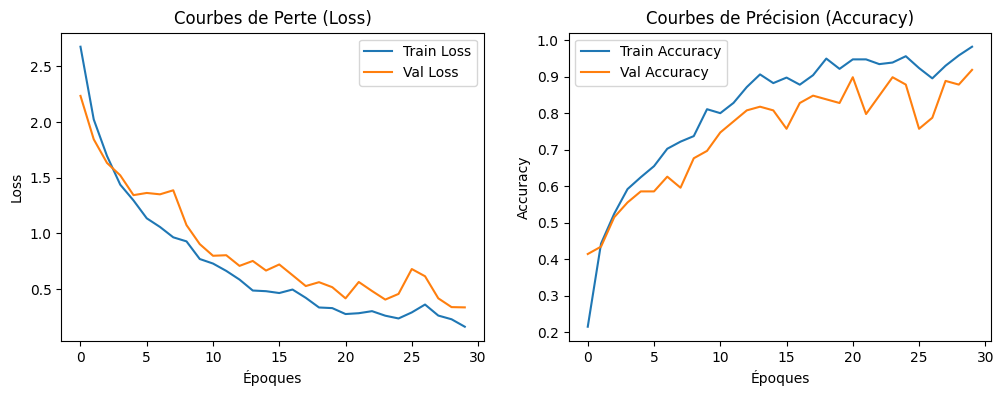

In [27]:
plot_history(history)

### 4. Évaluation

#### Question 4.a

On évalue les performances sur les jeux de train et de test :

In [28]:
# Évaluation sur le jeu d'entraînement
print("Performances sur le jeu d'entraînement (Train) :")
train_loss, train_acc = model_mlp.evaluate(X_train_norm, y_train_cat, verbose=0)
print(f"Loss : {train_loss:.4f}")
print(f"Accuracy : {train_acc:.4f} ({train_acc:.2%})")

# Évaluation sur le jeu de test (Test)
print("\nPerformances sur le jeu de test (Test) :")
test_loss, test_acc = model_mlp.evaluate(X_test_norm, y_test_cat, verbose=0)
print(f"Loss : {test_loss:.4f}")
print(f"Accuracy : {test_acc:.4f} ({test_acc:.2%})")

Performances sur le jeu d'entraînement (Train) :
Loss : 0.1556
Accuracy : 0.9783 (97.83%)

Performances sur le jeu de test (Test) :
Loss : 0.4906
Accuracy : 0.8586 (85.86%)


#### Question 4.b

On récupère les prédictions sur le jeu de test :

In [29]:
y_pred_prob = model_mlp.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Les vrais labels (y_test_cat) sont en one-hot, on les repasse en entiers
y_true = np.argmax(y_test_cat, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


On calcule la matrice de confusion :

In [30]:
cm = confusion_matrix(y_true, y_pred_classes)

On affiche la matrice de confusion :

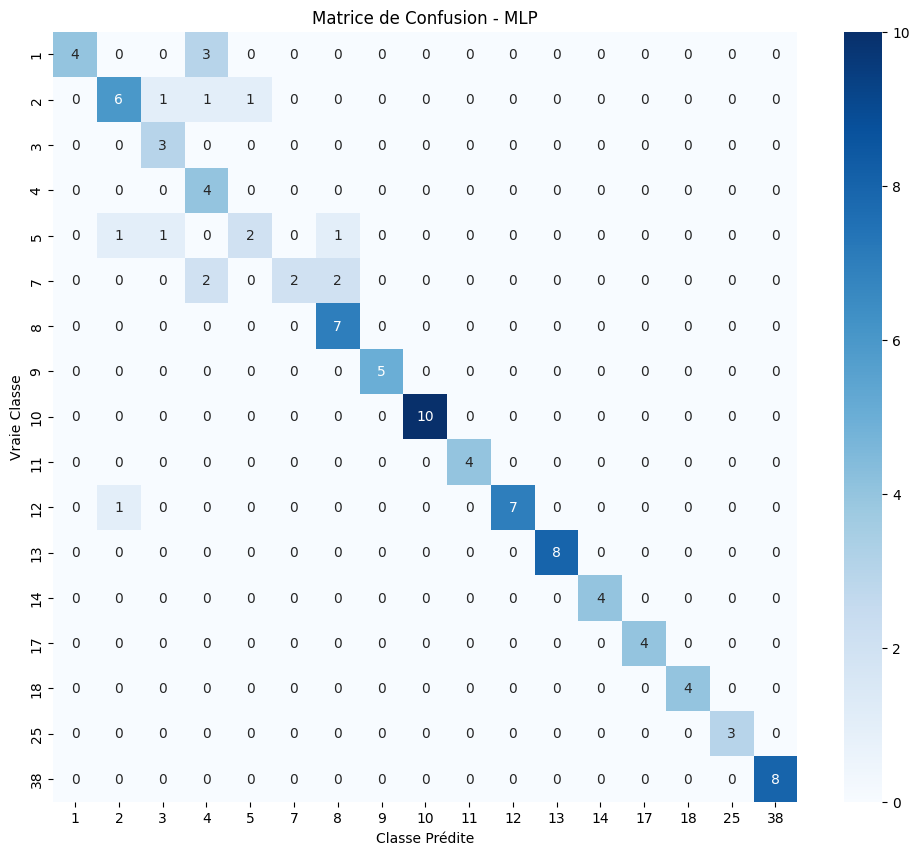

In [31]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, # Affiche les vrais IDs des classes
            yticklabels=le.classes_)
plt.title('Matrice de Confusion - MLP')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()

Voici le rapport de classification :

In [32]:
print(classification_report(y_true, y_pred_classes, target_names=[str(c) for c in le.classes_], zero_division=0))

              precision    recall  f1-score   support

           1       1.00      0.57      0.73         7
           2       0.75      0.67      0.71         9
           3       0.60      1.00      0.75         3
           4       0.40      1.00      0.57         4
           5       0.67      0.40      0.50         5
           7       1.00      0.33      0.50         6
           8       0.70      1.00      0.82         7
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00         4
          12       1.00      0.88      0.93         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         4
          17       1.00      1.00      1.00         4
          18       1.00      1.00      1.00         4
          25       1.00      1.00      1.00         3
          38       1.00      1.00      1.00         8

    accuracy              

#### Question 4.c

Le modèle MLP obtient une précision d'environ 86% sur le jeu de test. C'est un résultat honorable pour une telle approche, mais on observe un net sur-apprentissage : le modèle atteint presque 98% sur le jeu d'entraînement, mais perd 12 points sur le test. Il a "appris par cœur" les images d'entraînement mais peine à généraliser sur de nouvelles images.

Malgré ce score correct, le MLP présente des défauts majeurs pour l'image. Tout d'abord, l'opération Flatten() détruit la géométrie 2D (le fait qu'un pixel soit à côté d'un autre). Le réseau ne voit qu'une suite de chiffres et doit réapprendre des formes simples (ronds, triangles) à partir de zéro. De plus, si un panneau est décalé de quelques pixels, l'entrée change totalement pour le MLP. Il n'est pas "invariant par translation". Enfin, la première couche dense connecte chaque pixel à chaque neurone, ce qui crée un grand nombre de paramètres (plus de 800 000), favorisant le sur-apprentissage.

### Enregistrement du modèle MLP

In [152]:
model_mlp.save('mlp_traffic_signs.keras')

## Partie 3 - Classification avec couches CNN

### 1. Préparation des données

#### Question 1.a

On réutilisera les imagettes définies dans la partie précédente.

#### Question 1.b

On vérifie que les tenseurs ont la bonne forme (sachant que les CNN ont besoin d'un format du type (Batch_Size, Hauteur, Largeur, Canaux)) :

In [33]:
print(f"Forme des données d'entraînement : {X_train_norm.shape}")
print(f"Forme des données de validation  : {X_val_norm.shape}")
print(f"Forme des données de test        : {X_test_norm.shape}")

Forme des données d'entraînement : (461, 32, 32, 3)
Forme des données de validation  : (99, 32, 32, 3)
Forme des données de test        : (99, 32, 32, 3)


Les dimensions sont donc parfaites pour le CNN.

#### Question 1.c

On n'effectue pas de data augmentation pour les raisons évoquées dans la question 1.b de la partie 2.

### 2. Conception d’un réseau avec couches CNN

On conçoit le CNN :

In [34]:
model_cnn = Sequential([
    # --- Bloc d'extraction de caractéristiques (Feature Extraction) ---
    
    # Couche 1 : Convolution + ReLU + Pooling
    # 32 filtres de taille 3x3 pour détecter les petits détails (bords, lignes)
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), # Réduit l'image de moitié (16x16)
    
    # Couche 2 : Convolution + ReLU + Pooling
    # 64 filtres pour détecter des formes plus complexes
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), # Réduit l'image à 8x8
    
    # Couche 3 : Convolution + ReLU + Pooling
    # 128 filtres pour des concepts de haut niveau
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), # Réduit l'image à 4x4
    
    # --- Bloc de classification (Classifier) ---
    
    # Aplatissement pour passer aux couches denses
    Flatten(),
    
    # Couche dense avec Dropout pour éviter le sur-apprentissage
    Dense(128, activation='relu'),
    Dropout(0.5), # Extinction de 50% des neurones aléatoirement à chaque passe
    
    # Couche de sortie
    Dense(num_classes, activation='softmax')
])

Voici un résumé du CNN construit :

In [35]:
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,713 (1.36 MB)

 Trainable params: 357,713 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

### 3. Entraînement

On compile le modèle :

In [36]:
model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

On entraîne le modèle en reprenant le générateur de data augmentation configuré dans la question 1.b de la partie 2 :

In [37]:
history_cnn = model_cnn.fit(
    x=X_train_norm, 
    y=y_train_cat,
    batch_size=32,
    epochs=30,
    validation_data=(X_val_norm, y_val_cat),
    verbose=1
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0846 - loss: 2.7959 - val_accuracy: 0.0909 - val_loss: 2.6942
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1540 - loss: 2.6413 - val_accuracy: 0.1616 - val_loss: 2.5302
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1974 - loss: 2.4956 - val_accuracy: 0.3030 - val_loss: 2.4073
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2863 - loss: 2.3429 - val_accuracy: 0.3030 - val_loss: 2.2584
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3492 - loss: 2.1725 - val_accuracy: 0.4343 - val_loss: 2.0487
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3839 - loss: 1.9689 - val_accuracy: 0.4646 - val_loss: 1.8152
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4707 - loss: 1.7069 - val_accuracy: 0.5354 - val_loss: 1.5072
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4989 - loss: 1.5962 - val_accuracy: 0.5657 - v

On trace les courbes loss / accuracy :

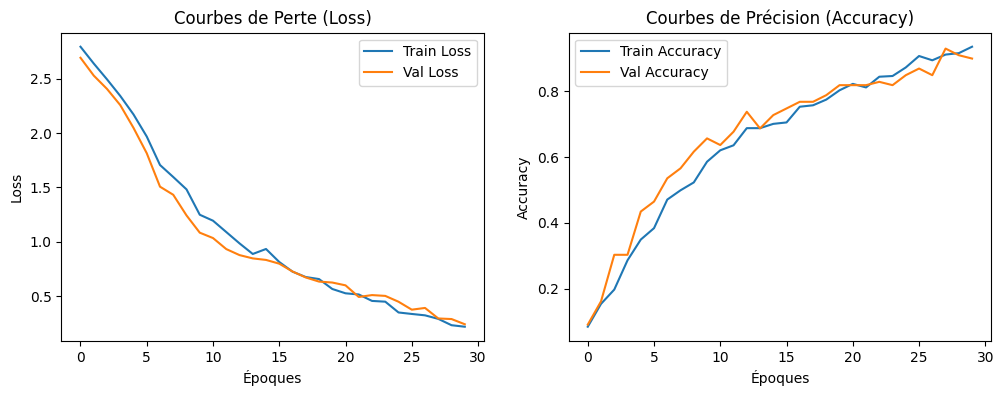

In [38]:
plot_history(history_cnn)

### 4. Évaluation

On évalue les performances sur les jeux de train et de test :

In [39]:
# Évaluation sur le jeu d'entraînement
print("Performances sur le jeu d'entraînement (Train) :")
train_loss, train_acc = model_cnn.evaluate(X_train_norm, y_train_cat, verbose=0)
print(f"Loss : {train_loss:.4f}")
print(f"Accuracy : {train_acc:.4f} ({train_acc:.2%})")

# Évaluation sur le jeu de test (Test)
print("\nPerformances sur le jeu de test (Test) :")
test_loss, test_acc = model_cnn.evaluate(X_test_norm, y_test_cat, verbose=0)
print(f"Loss : {test_loss:.4f}")
print(f"Accuracy : {test_acc:.4f} ({test_acc:.2%})")

Performances sur le jeu d'entraînement (Train) :
Loss : 0.0587
Accuracy : 0.9957 (99.57%)

Performances sur le jeu de test (Test) :
Loss : 0.2925
Accuracy : 0.9192 (91.92%)


On récupère les prédictions sur le jeu de test :

In [42]:
y_pred_prob_cnn = model_cnn.predict(X_test_norm)
y_pred_cnn = np.argmax(y_pred_prob_cnn, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


On calcule les matrices de confusion des deux modèles pour comparaison :

In [43]:
cm_cnn = confusion_matrix(y_true, y_pred_cnn)

On affiche la matrice de confusion :

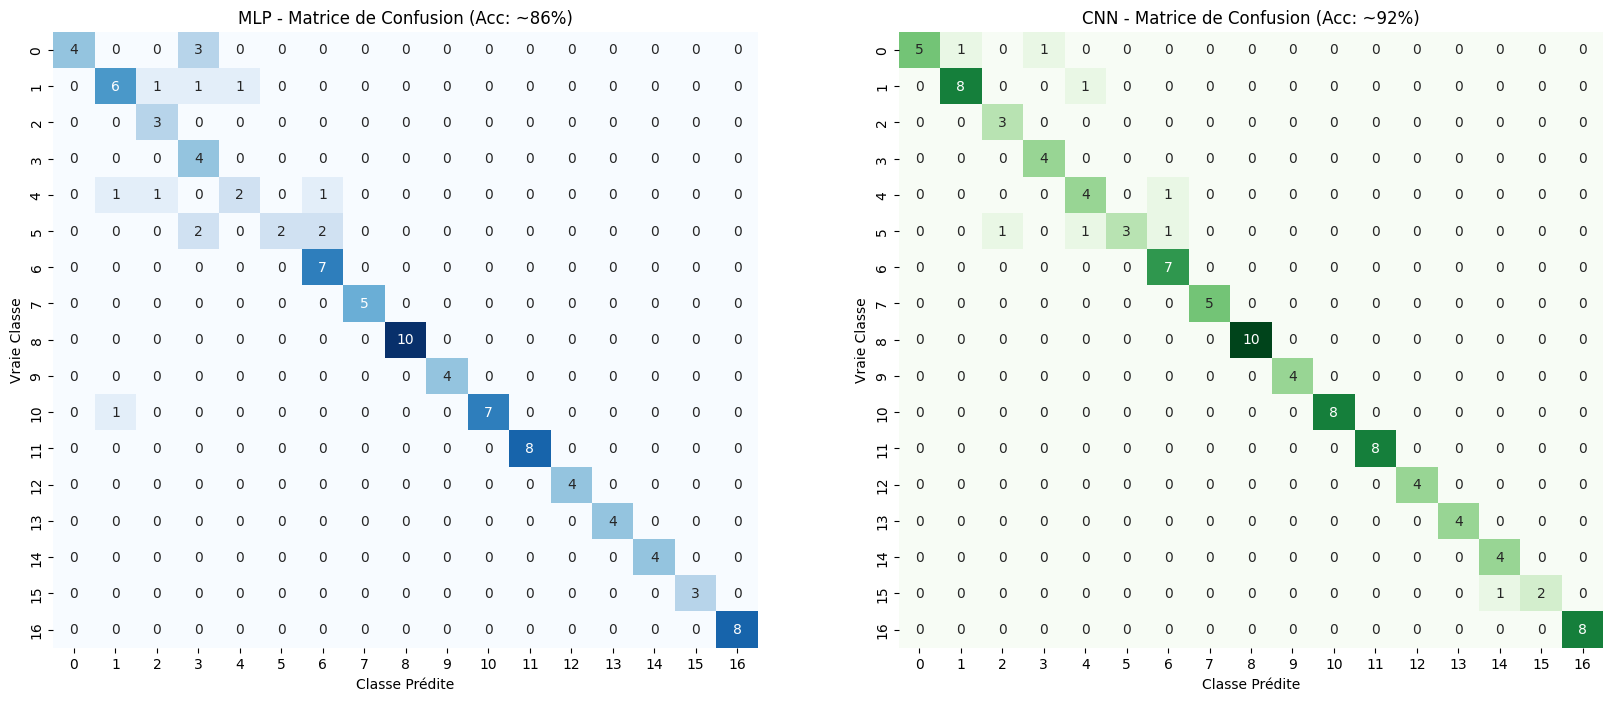

In [46]:
plt.figure(figsize=(20, 8))

# Matrice MLP
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('MLP - Matrice de Confusion (Acc: ~86%)')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')

# Matrice CNN
plt.subplot(1, 2, 2)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('CNN - Matrice de Confusion (Acc: ~92%)')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')

plt.show()

Voici le rapport de classification :

In [45]:
print(classification_report(y_true, y_pred_cnn, target_names=[str(c) for c in le.classes_], zero_division=0))

              precision    recall  f1-score   support

           1       1.00      0.71      0.83         7
           2       0.89      0.89      0.89         9
           3       0.75      1.00      0.86         3
           4       0.80      1.00      0.89         4
           5       0.67      0.80      0.73         5
           7       1.00      0.50      0.67         6
           8       0.78      1.00      0.88         7
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         4
          17       1.00      1.00      1.00         4
          18       0.80      1.00      0.89         4
          25       1.00      0.67      0.80         3
          38       1.00      1.00      1.00         8

    accuracy              

Le passage au CNN a permis une amélioration significative des performances. Nous sommes passés d'une précision d'environ 86% avec le MLP à environ 92% avec le CNN sur le jeu de test. La matrice de confusion du CNN montre une diagonale plus nette et une réduction des confusions entre les classes visuellement proches.

Cette supériorité s'explique par l'architecture même des réseaux convolutifs, adaptée au traitement d'images. En effet, contrairement au MLP qui "écrase" l'image en un vecteur plat (perdant ainsi les relations de voisinage entre les pixels), le CNN traite l'image en 2D. Il peut donc identifier des formes géométriques (cercles, triangles) essentielles aux panneaux. Ensuite, les filtres de convolution détectent des motifs (bords, couleurs) indépendamment de leur position globale dans l'image. Enfin, grâce aux couches de MaxPooling, le CNN reconnaît un panneau même s'il est légèrement décentré, là où un MLP verrait une entrée totalement différente.

Pour conclure, bien que le CNN offre de bons résultats, il plafonne autour de 92% à cause de la taille restreinte du jeu de données (seulement ~27 images par classe), ce qui limite sa capacité de généralisation. Pour franchir ce palier, l'utilisation du Transfert de Connaissances (Transfer Learning) dans la partie suivante est tout indiquée.

### Enregistrement du modèle CNN

In [153]:
model_cnn.save('cnn_traffic_signs.keras')

## Partie 4 - Transfert de connaissances (Transfer Learning)

### 1. Mise en place du transfert de connaissances

On charge le modèle pré-entraîné `VGG16` car il est très performant, même sur de petites images :

In [67]:
base_model = VGG16(
    weights='imagenet', # On charge les connaissances acquises sur ImageNet
    include_top=False, # On retire la couche finale (qui classifiait 1000 objets différents)
    input_shape=(32, 32, 3) # On adapte l'entrée à la taille de nos panneaux
)

Comme nos images (32x32) sont très différentes des images haute résolution sur lesquelles VGG16 a été entraîné (ImageNet), il est nécessaire de laisser le modèle adapter ses poids pour apprendre les caractéristiques spécifiques aux panneaux pixélisés :

In [68]:
for layer in base_model.layers:
    layer.trainable = True

On ajoute la nouvelle tête de classification :

In [69]:
x = base_model.output

x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D est souvent plus stable pour le Transfer Learning que le Flatten classique.

# Couche dense intermédiaire
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout pour éviter le sur-apprentissage

# Couche de sortie adaptée au nombre de classes
predictions = Dense(num_classes, activation='softmax')(x)

# Création du modèle final
model_tl = Model(inputs=base_model.input, outputs=predictions)

On compile le modèle en utilisant un learning rate légèrement plus faible (1e-4) pour ne pas brusquer l'apprentissage :

In [70]:
model_tl.compile(optimizer=Adam(learning_rate=1e-4),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

Voici un résumé du modèle :

In [71]:
model_tl.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,850,385 (56.65 MB)

 Trainable params: 14,850,385 (56.65 MB)

 Non-trainable params: 0 (0.00 B)

### 2. Entraînement du modèle pré-entraîné

On entraîne le modèle sur `X_train_norm` et `y_train_cat` :

In [72]:
history_tl = model_tl.fit(
    X_train_norm, y_train_cat,
    batch_size=32,
    epochs=20,
    validation_data=(X_val_norm, y_val_cat),
    verbose=1
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 732ms/step - accuracy: 0.2126 - loss: 2.4970 - val_accuracy: 0.4646 - val_loss: 1.7612
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 696ms/step - accuracy: 0.4534 - loss: 1.6869 - val_accuracy: 0.5657 - val_loss: 1.3493
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 698ms/step - accuracy: 0.5618 - loss: 1.3496 - val_accuracy: 0.6162 - val_loss: 1.1160
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 687ms/step - accuracy: 0.5510 - loss: 1.2571 - val_accuracy: 0.6263 - val_loss: 1.0882
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 691ms/step - accuracy: 0.6464 - loss: 1.0080 - val_accuracy: 0.5657 - val_loss: 1.1760
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 682ms/step - accuracy: 0.6594 - loss: 0.9822 - val_accuracy: 0.6061 - val_loss: 0.9297
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 701ms/step - accuracy: 0.7245 - loss: 0.8191 - val_accuracy: 0.8182 - val_loss: 0.6701
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 680ms/step - accuracy: 0.7570 - loss: 0.6906 - val_accu

### 3. Comparaison des performances

On trace les courbes loss / accuracy :

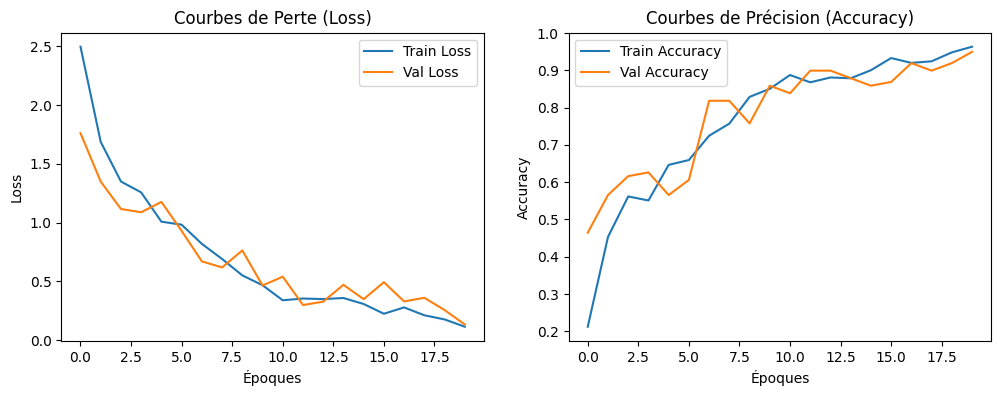

In [73]:
plot_history(history_tl)

On évalue le modèle sur les données de test :

In [75]:
loss_tl, acc_tl = model_tl.evaluate(X_test_norm, y_test_cat, verbose=0)
print(f"Loss : {loss_tl:.4f}")
print(f"Accuracy : {acc_tl:.4f} ({acc_tl:.0%})")

Loss : 0.2212
Accuracy : 0.9293 (93%)


Le CNN dans la partie précédente présentait un accuracy de 92%, là où le modèle VGG16 fine-tuné présente un accuracy de 93%. Le Transfer Learning parvient à dépasser légèrement le CNN spécialisé. C'est un résultat remarquable car VGG16 n'est pas conçu pour des images aussi petites, mais sa capacité d'adaptation (grâce au déblocage des poids) lui permet de compenser.

Sur le VGG16, les courbes de validation collent presque parfaitement aux courbes d'entraînement. À l'époque 20, nous avons 96% en train et 95% en validation. Contrairement au MLP ou au CNN qui avaient tendance à monter à 99% en train pour stagner à 85-90% en test (overfitting), le VGG16 généralise beaucoup mieux. Il ne sur-apprend pas les données.

Le VGG16 part de plus loin (loss initiale > 2.0) car il doit "désapprendre" ses filtres HD pour s'adapter au 32x32. Cependant, une fois la descente amorcée (vers l'époque 7-8), la perte chute de manière monotone et régulière, sans les pics ou instabilités souvent observés sur les réseaux entraînés de zéro.

Pour conclure, le Full Fine-Tuning de VGG16 est la méthode la plus robuste. Bien que le score final soit proche du CNN (93% vs 92%), la stabilité exemplaire des courbes de validation prouve que ce modèle est plus fiable et généralise mieux sur de nouvelles données.

### Enregistrement du modèle pré-entraîné VGG16 (Transfer Learning)

In [154]:
model_tl.save('vgg16_finetuned_traffic_signs.keras')

## Partie 5 - Localisation

### 1. Génération des données

On commence par écrire une fonction qui applique une rotation à une liste de points autour d'un centre :

In [124]:
def rotate_points(points, angle, center):
    angle_rad = math.radians(angle)
    cos_theta = math.cos(angle_rad)
    sin_theta = math.sin(angle_rad)
    cx, cy = center
    
    rotated_points = []
    for x, y in points:
        # Translation pour ramener au centre (0,0)
        tx, ty = x - cx, y - cy
        # Rotation
        rx = tx * cos_theta - ty * sin_theta
        ry = tx * sin_theta + ty * cos_theta
        # Translation inverse
        rotated_points.append([rx + cx, ry + cy])
        
    return np.array(rotated_points, dtype=np.int32)

On écrit une fonction qui génère des images binaires (noir et blanc) contenant une forme géométrique (carré, cercle ou triangle) :

In [127]:
def create_training_data_with_rotation(num_samples=1000, img_size=64):
    X = np.zeros((num_samples, img_size, img_size, 1), dtype='float32')
    y = np.zeros((num_samples, 4), dtype='float32')
    
    for i in range(num_samples):
        img = np.zeros((img_size, img_size), dtype='uint8')
        
        # Dimensions aléatoires
        w = np.random.randint(15, 30)
        h = np.random.randint(15, 30)
        
        # Position du centre de la forme
        # On garde une marge pour ne pas sortir de l'image après rotation
        cx = np.random.randint(w, img_size - w)
        cy = np.random.randint(h, img_size - h)
        
        # Angle de rotation aléatoire (0 à 360 degrés)
        angle = np.random.randint(0, 360)
        
        shape_type = np.random.randint(0, 3) # 0 = Rectangle, 1 = Cercle, 2 = Triangle
        
        # Pour stocker les points qui serviront à calculer la bounding box
        points_to_box = []
        
        if shape_type == 0: # Rectangle
            # On définit les 4 coins par rapport au centre cx, cy
            pts = [
                (cx - w//2, cy - h//2),
                (cx + w//2, cy - h//2),
                (cx + w//2, cy + h//2),
                (cx - w//2, cy + h//2)
            ]
            # On applique la rotation
            rotated_pts = rotate_points(pts, angle, (cx, cy))
            cv2.fillConvexPoly(img, rotated_pts, 255)
            points_to_box = rotated_pts
            
        elif shape_type == 1: # Cercle
            # La rotation d'un cercle ne change rien à sa forme ni sa bbox
            radius = min(w, h) // 2
            cv2.circle(img, (cx, cy), radius, 255, -1)
            # La bbox est simple : centre +/- rayon
            points_to_box = [
                (cx - radius, cy - radius),
                (cx + radius, cy + radius)
            ]
            
        elif shape_type == 2: # Triangle
            # Triangle équilatéral approximatif centré
            pts = [
                (cx, cy - h//2),            # Haut
                (cx - w//2, cy + h//2),     # Bas Gauche
                (cx + w//2, cy + h//2)      # Bas Droite
            ]
            rotated_pts = rotate_points(pts, angle, (cx, cy))
            cv2.fillConvexPoly(img, rotated_pts, 255)
            points_to_box = rotated_pts

        # Calcul de la bounding box (Étiquettes)
        # On trouve les x_min, y_min, x_max, y_max des points tournés
        pts_array = np.array(points_to_box)
        x_min, y_min = np.min(pts_array, axis=0)
        x_max, y_max = np.max(pts_array, axis=0)
        
        # Sécurité : on s'assure que la bbox ne sort pas de l'image (0-63)
        x_min = max(0, x_min); y_min = max(0, y_min)
        x_max = min(img_size, x_max); y_max = min(img_size, y_max)
        
        # Normalisation
        X[i, :, :, 0] = img / 255.0
        y[i] = [x_min/img_size, y_min/img_size, x_max/img_size, y_max/img_size]
        
    return X, y

On génère les données :

In [128]:
X_loc_train, y_loc_train = create_training_data_with_rotation(2000)
X_loc_val, y_loc_val = create_training_data_with_rotation(500)
print(f"Données de localisation générées.")
print(f"X shape: {X_loc_train.shape}")
print(f"y shape: {y_loc_train.shape}")

Données de localisation générées.
X shape: (2000, 64, 64, 1)
y shape: (2000, 4)


On visualise les données générées pour vérifier :

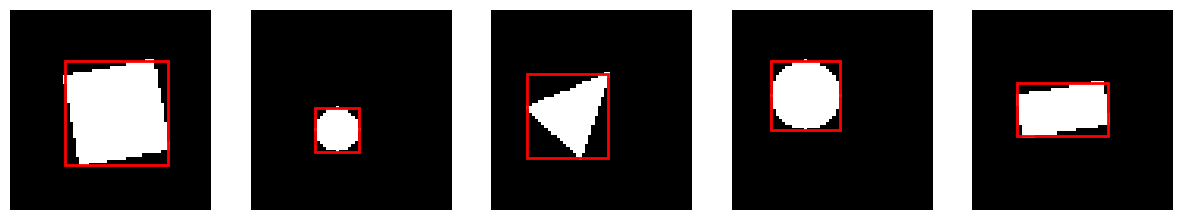

In [129]:
plt.figure(figsize=(15, 3))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    idx = np.random.randint(0, len(X_loc_train))
    
    img = X_loc_train[idx].reshape(64, 64)
    plt.imshow(img, cmap='gray')
    
    box = y_loc_train[idx] * 64
    rect = patches.Rectangle(
        (box[0], box[1]), 
        box[2] - box[0], 
        box[3] - box[1], 
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    ax.axis('off')
plt.show()

### 2. Apprentissage et test du réseau

On conçoit le CNN de localisation :

In [130]:
model_loc = Sequential([
    Input(shape=(64, 64, 1)), #  1 seul canal (N&B)
    
    # Extraction de caractéristiques (Bords, Formes)
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Tête de régression
    Flatten(),
    Dense(128, activation='relu'),
    
    # Sortie : 4 neurones pour (x1, y1, x2, y2)
    # Sigmoid force la sortie entre 0 et 1 (parfait pour nos coordonnées normalisées)
    Dense(4, activation='sigmoid') 
])

On compile ensuite le modèle en choisissant MSE comme fonction de coût (car c'est la fonction de coût standard pour la régression) :

In [131]:
model_loc.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae'] # Mean Absolute Error
)

Voici un résumé du modèle :

In [132]:
model_loc.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 359,940 (1.37 MB)

 Trainable params: 359,940 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

On entraîne le CNN sur `X_loc_train` et `y_loc_train` :

In [133]:
history_loc = model_loc.fit(
    X_loc_train, y_loc_train,
    batch_size=32,
    epochs=15,
    validation_data=(X_loc_val, y_loc_val),
    verbose=1
)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0041 - mae: 0.0412 - val_loss: 5.9214e-04 - val_mae: 0.0179
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 3.8785e-04 - mae: 0.0144 - val_loss: 2.7001e-04 - val_mae: 0.0121
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1.8205e-04 - mae: 0.0096 - val_loss: 1.6533e-04 - val_mae: 0.0090
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 1.3023e-04 - mae: 0.0084 - val_loss: 1.4388e-04 - val_mae: 0.0085
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 9.7637e-05 - mae: 0.0072 - val_loss: 1.0703e-04 - val_mae: 0.0070
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 6.5738e-05 - mae: 0.0058 - val_loss: 7.9946e-05 - val_mae: 0.0060
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 5.7120e-05 - mae: 0.0055 - val_loss: 6.9210e-05 - val_mae: 0.0057
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.8466e-05 - mae: 0.0051 - val_loss: 6.0388e-05 - val_mae: 0.0053
Epoc

On génère un jeu de test avec les mêmes variations (translation, rotation, échelle) :

In [ ]:
X_loc_test, y_loc_test = create_training_data_with_rotation(500)

On évalue le modèle sur le jeu de test généré :

In [135]:
loss, mae = model_loc.evaluate(X_loc_test, y_loc_test, verbose=0)
print(f"Erreur moyenne (MAE) : {mae * 64:.2f} pixels")

Erreur moyenne (MAE) : 0.31 pixels


Avec une erreur moyenne absolue (MAE) de seulement 0.31 pixels sur des images de taille 64×64, le modèle atteint une précision sub-pixel. Cela démontre que le réseau a parfaitement convergé et a acquis une invariance totale aux transformations géométriques imposées (translation, rotation et changement d'échelle), rendant les prédictions virtuellement parfaites.

On peut aussi visualiser les prédictions :

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


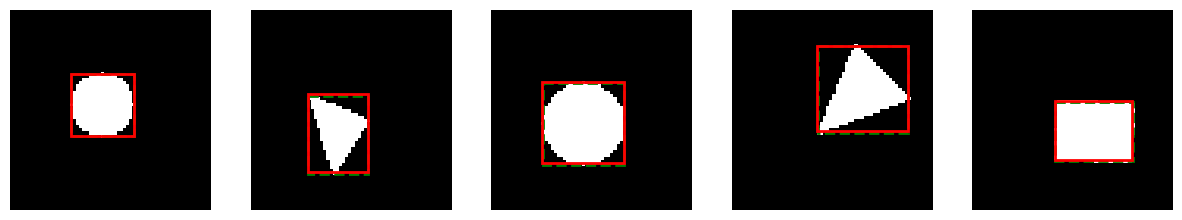

In [136]:
y_pred = model_loc.predict(X_loc_test)

plt.figure(figsize=(15, 4))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    idx = np.random.randint(0, len(X_loc_test))
    
    img = X_loc_test[idx].reshape(64, 64)
    plt.imshow(img, cmap='gray')
    
    # Vraie boîte (Vert pointillés)
    gt = y_loc_test[idx] * 64
    rect_gt = patches.Rectangle((gt[0], gt[1]), gt[2]-gt[0], gt[3]-gt[1],
                                linewidth=2, edgecolor='g', facecolor='none', linestyle='--')
    ax.add_patch(rect_gt)
    
    # Prédiction (Rouge plein)
    pred = y_pred[idx] * 64
    rect_pred = patches.Rectangle((pred[0], pred[1]), pred[2]-pred[0], pred[3]-pred[1],
                                  linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect_pred)
    ax.axis('off')
plt.show()

### 3. Extension du scénario

On créé une fonction qui place 2 ou 3 formes dans l'image au lieu d'une seule :

In [137]:
def create_multi_object_data(num_samples=100, img_size=64, max_objects=3):
    X = np.zeros((num_samples, img_size, img_size, 1), dtype='float32')
    ground_truth_boxes = [] 
    
    for i in range(num_samples):
        img = np.zeros((img_size, img_size), dtype='uint8')
        
        # Nombre aléatoire d'objets (2 ou 3)
        num_objs = np.random.randint(2, max_objects + 1)
        boxes = []
        
        for _ in range(num_objs):
            w = np.random.randint(10, 20)
            h = np.random.randint(10, 20)
            x = np.random.randint(0, img_size - w)
            y_pos = np.random.randint(0, img_size - h)
            
            # On dessine un rectangle (pour simplifier)
            cv2.rectangle(img, (x, y_pos), (x+w, y_pos+h), 255, -1)
            boxes.append([x, y_pos, x+w, y_pos+h])
            
        X[i, :, :, 0] = img / 255.0
        ground_truth_boxes.append(boxes)
        
    return X, ground_truth_boxes

On génère les données :

In [138]:
X_multi, y_multi_boxes = create_multi_object_data(num_samples=10)
print("Données multi-objets générées.")

Données multi-objets générées.


On visualise les prédictions :

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


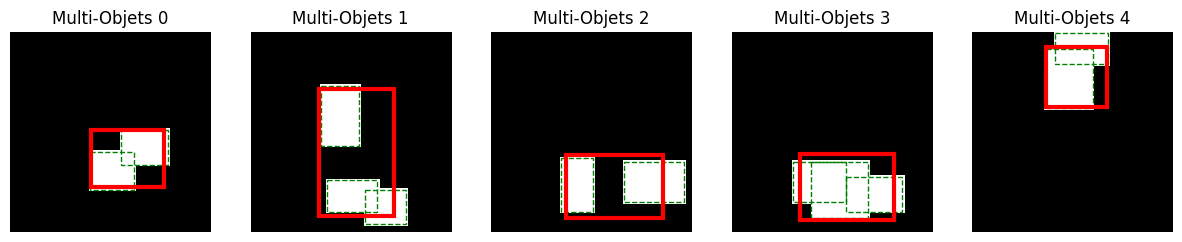

In [151]:
y_pred_multi = model_loc.predict(X_multi)

plt.figure(figsize=(15, 6))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    
    # Image
    img = X_multi[i].reshape(64, 64)
    plt.imshow(img, cmap='gray')
    
    # On dessiner les vraies boîtes en vert
    # Il y en a plusieurs par image
    for box in y_multi_boxes[i]:
        rect_gt = patches.Rectangle(
            (box[0], box[1]), box[2]-box[0], box[3]-box[1],
            linewidth=1, edgecolor='g', facecolor='none', linestyle='--'
        )
        ax.add_patch(rect_gt)
        
    # On dessine la prédiction du réseau en rouge
    # Le réseau ne sort qu'une seule boîte quoi qu'il arrive (car il a été entraîné avec 4 neurones de sortie)
    pred = y_pred_multi[i] * 64
    rect_pred = patches.Rectangle(
        (pred[0], pred[1]), pred[2]-pred[0], pred[3]-pred[1],
        linewidth=3, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect_pred)
    
    ax.axis('off')
    ax.set_title(f"Multi-Objets {i}")

plt.show()

Comme le montre la visualisation, après avoir testé le réseau sur des images contenant plusieurs formes. le modèle échoue à détecter toutes les occurrences. En fait, l'architecture du réseau est conçue avec une couche de sortie fixe de 4 neurones (Dense(4)). Il ne peut physiquement prédire qu'une seule boîte englobante par image. Face à plusieurs objets, le réseau prédit une boîte "moyenne" située entre les objets, ou englobant l'ensemble, ce qui ne constitue pas une localisation précise.

Pour gérer le multi-objets, il faudrait changer d'architecture pour des modèles comme YOLO (You Only Look Once) ou SSD, qui utilisent des grilles d'ancres (Anchor Boxes) pour prédire N boîtes potentielles par image.

### Enregistrement du modèle CNN de localisation

In [156]:
model_loc.save('cnn_localization.keras')

## Partie 6 - Synthèse et comparaison globale

### a. Comparaison MLP vs CNN

| Modèle | Précision Test | Paramètres | Observation |
|--------|-----------------|------------|-------------|
| MLP    | ~86%            | ~800k      | Sur-apprentissage marqué. Perte de la structure spatiale de l'image. |
| CNN    | ~92%            | ~350k      | Meilleure généralisation. Invariance aux translations grâce aux convolutions. |

Le passage du MLP au CNN a apporté un gain significatif de +6% tout en divisant le nombre de paramètres par deux. Le MLP échoue à capter les invariances géométriques (un panneau décalé change toute l'entrée), tandis que le CNN, grâce à ses filtres locaux et au pooling, excelle à reconnaître les formes (cercles, triangles) indépendamment de leur position exacte.

### b. Comparaison CNN vs CNN pré-entraîné (transfert de connaissances)

| Modèle              | Précision Test | Stabilité   | Observation                                                             |
|---------------------|-----------------|-------------|-------------------------------------------------------------------------|
| CNN                 | 92%             | Moyenne     | Très efficace pour la faible résolution (32x32).                        |
| VGG16 (Fine-Tuned)  | 93%             | Excellente  | Courbes d'apprentissage parfaites, aucune divergence Train/Val.       |


En appliquant un Full Fine-Tuning (déblocage des poids), le modèle pré-entraîné VGG16 a pu adapter ses filtres profonds à nos images basse résolution pour atteindre la meilleure performance du projet (93%). Bien que le gain en précision pure soit modeste (+1%) par rapport au CNN de la partie 3, le modèle est beaucoup plus robuste et stable.

### c. Conclusion générale

Nos expérimentations sur la base GTSDB confirment la supériorité théorique des Réseaux de Neurones Convolutifs (CNN) sur les Perceptrons Multicouches (MLP) pour le traitement d'images.

- Le **MLP** (~86%) atteint rapidement ses limites car il ignore la topologie spatiale de l'image.

- Le **CNN** (~92%) s'avère extrêmement efficace pour des images de faible résolution (32×32), offrant un excellent compromis entre légèreté et performance.

- Le **Transfert de Connaissances (VGG16)** a démontré sa robustesse (~93%) mais a mis en lumière l'importance du Fine-Tuning : sans déblocage des poids, un modèle pré-entraîné sur des images HD peine à s'adapter à des vignettes pixelisées.

La partie Localisation (partie 5) a prouvé qu'un CNN peut efficacement réaliser des tâches de régression (prédire des coordonnées avec une précision sub-pixel de 0.31 px) tant que le nombre d'objets est fixe. L'échec du modèle sur des scènes multi-objets illustre la nécessité de passer à des architectures plus complexes basées sur des ancres, comme YOLO ou SSD, pour des applications réelles de conduite autonome.

Bilan : En conclusion, ce travail souligne qu'il n'existe pas d'architecture "universelle". Le choix du modèle dépend intimement de la nature des données (résolution, volume) et de la tâche visée. Pour GTSDB, l'approche hybride (Transfer Learning avec Fine-Tuning) reste la plus fiable, bien qu'un petit CNN bien conçu soit étonnamment compétitif.